# Delineation of (sub)basins

Here we assume that flow directions are known. We read the flow direction raster data, including meta-data, using [rasterio](https://rasterio.readthedocs.io/en/latest/) and parse it to a pyflwdir `FlwDirRaster` object, see earlier examples for more background.

In [1]:
# import pyflwdir, some dependencies
import geopandas as gpd
import numpy as np
import rasterio
import pyflwdir

# local convenience methods (see utils.py script in notebooks folder)
from utils import vectorize  # convenience method to vectorize rasters
from utils import quickplot, colors, cm  # data specific quick plot method

# read and parse data
with rasterio.open("rhine_d8.tif", "r") as src:
    flwdir = src.read(1)
    crs = src.crs
    flw = pyflwdir.from_array(
        flwdir,
        ftype="d8",
        transform=src.transform,
        latlon=crs.is_geographic,
        cache=True,
    )

## Outlet based (sub)basins

The [basins()](reference.rst#pyflwdir.FlwdirRaster.basins) method delineates (sub)basins defined by its outlet location. 
By default the method uses pits from the flow direction raster as outlets to delineate basins, but if outlet locations are profided these are used instead. An additional `streams` argument can be added to make sure the outlet locations are snapped to the nearest downstream stream cell, using the [snap()](reference.rst#pyflwdir.FlwdirRaster.snap) method under the hood. Here streams are defined by a minimum Strahler stream order of 4.

In [2]:
# define output locations
x, y = np.array([4.67916667, 7.60416667]), np.array([51.72083333, 50.3625])
gdf_out = gpd.GeoSeries(gpd.points_from_xy(x, y, crs=4326))
# delineate subbasins
subbasins = flw.basins(xy=(x, y), streams=flw.stream_order() >= 4)
# vectorize subbasins using the vectorize convenience method from utils.py
gdf_bas = vectorize(subbasins.astype(np.int32), 0, flw.transform, name="basin")
gdf_bas.head()

,geometry,basin
0,"POLYGON ((5.55833 51.89167, 5.58333 51.89167, ...",1
1,"POLYGON ((6.45833 50.42500, 6.47500 50.42500, ...",2


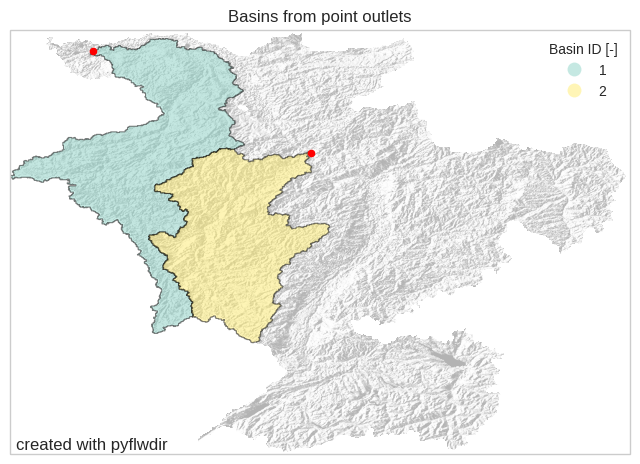

In [3]:
# plot
# key-word arguments passed to GeoDataFrame.plot()
gpd_plot_kwds = dict(
    column="basin",
    cmap=cm.Set3,
    legend=True,
    categorical=True,
    legend_kwds=dict(title="Basin ID [-]"),
    alpha=0.5,
    edgecolor="black",
    linewidth=0.8,
)
points = (gdf_out, dict(color="red", markersize=20))
bas = (gdf_bas, gpd_plot_kwds)
# plot using quickplot convenience method from utils.py
ax = quickplot([bas, points], title="Basins from point outlets", filename="flw_basins")

## Stream order subbasins

The [subbasins_streamorder()](reference.rst#pyflwdir.FlwdirRaster.subbasins_streamorder) method creates subbasins at all confluences where each branch has a minimal stream order set by `min_sto`. An optional mask can be added to select a subset of the outlets (i.e. confluences) which are located inside the mask.

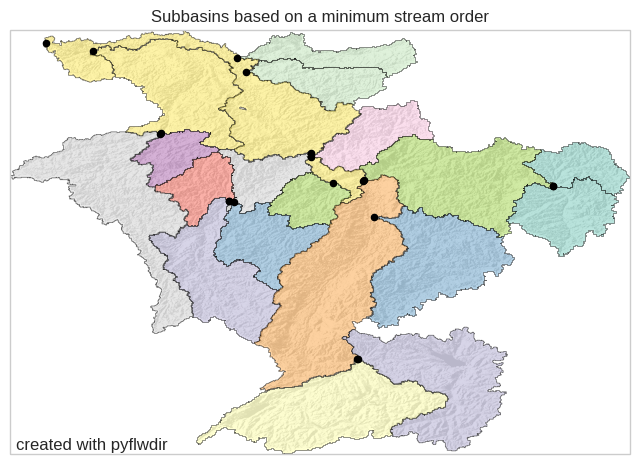

In [4]:
# calculate subbasins with a minimum stream order 7 and its outlets
subbas, idxs_out = flw.subbasins_streamorder(min_sto=7, mask=None)
# transfrom map and point locations to GeoDataFrames
gdf_subbas = vectorize(subbas.astype(np.int32), 0, flw.transform, name="basin")
gdf_out = gpd.GeoSeries(gpd.points_from_xy(*flw.xy(idxs_out), crs=4326))
# plot
gpd_plot_kwds = dict(
    column="basin", cmap=cm.Set3, edgecolor="black", alpha=0.6, linewidth=0.5
)
bas = (gdf_subbas, gpd_plot_kwds)
points = (gdf_out, dict(color="k", markersize=20))
title = "Subbasins based on a minimum stream order"
ax = quickplot([bas, points], title=title, filename="flw_subbasins")

## Pfafstetter subbasins

The [subbasins_pfafstetter()](reference.rst#pyflwdir.FlwdirRaster.subbasins_pfafstetter) method creates subbasins with the hierarchical pfafstetter coding system. It is designed such that topological information is embedded in the code, which makes it easy to determine whether a subbasin is downstream of another subbasin. At each level the four largest subbasins have even numbers and five largest interbasins have odd numbers. The `depth` argument is used to set the number of subbasin levels, i.e.: `depth=1` nine, and with `depth=2` 81 sub/interbasins are found. The `subbasins_pfafstetter` method requires upstream area of each cell, which is calculated on the fly if not provided with the `uparea` argument.

In [5]:
# get the first level nine pfafstetter basins
pfafbas1, idxs_out = flw.subbasins_pfafstetter(depth=1)
# vectorize raster to obtain polygons
gdf_pfaf1 = vectorize(pfafbas1.astype(np.int32), 0, flw.transform, name="pfaf")
gdf_out = gpd.GeoSeries(gpd.points_from_xy(*flw.xy(idxs_out), crs=4326))
gdf_pfaf1.head()

,geometry,pfaf
0,"POLYGON ((4.10833 51.92500, 4.14167 51.92500, ...",1
1,"POLYGON ((5.88333 52.00833, 5.91667 52.00833, ...",3
2,"POLYGON ((8.95000 51.07500, 8.96667 51.07500, ...",5
3,"POLYGON ((8.96667 50.61667, 8.98333 50.61667, ...",6
4,"POLYGON ((5.55833 51.89167, 5.58333 51.89167, ...",2


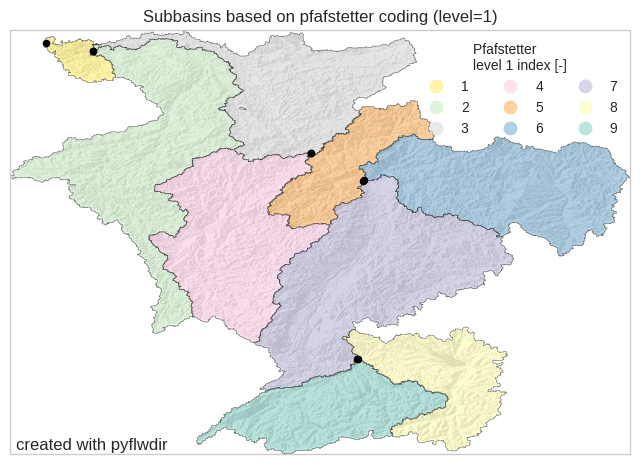

In [6]:
# plot
gpd_plot_kwds = dict(
    column="pfaf",
    cmap=cm.Set3_r,
    legend=True,
    categorical=True,
    legend_kwds=dict(title="Pfafstetter \nlevel 1 index [-]", ncol=3),
    alpha=0.6,
    edgecolor="black",
    linewidth=0.4,
)

points = (gdf_out, dict(color="k", markersize=20))
bas = (gdf_pfaf1, gpd_plot_kwds)
title = "Subbasins based on pfafstetter coding (level=1)"
ax = quickplot([bas, points], title=title, filename="flw_pfafbas1")

In [7]:
# lets create a second pfafstetter layer with a minimum subbasin area of 5000 km2
pfafbas2, idxs_out = flw.subbasins_pfafstetter(depth=2, upa_min=5000)
gdf_pfaf2 = vectorize(pfafbas2.astype(np.int32), 0, flw.transform, name="pfaf2")
gdf_out = gpd.GeoSeries(gpd.points_from_xy(*flw.xy(idxs_out), crs=4326))
gdf_pfaf2["pfaf"] = gdf_pfaf2["pfaf2"] // 10
gdf_pfaf2.head()

,geometry,pfaf2,pfaf
0,"POLYGON ((5.88333 52.00833, 5.91667 52.00833, ...",31,3
1,"POLYGON ((7.32500 51.97500, 7.34167 51.97500, ...",32,3
2,"POLYGON ((6.58333 51.63333, 6.60000 51.63333, ...",33,3
3,"POLYGON ((4.10833 51.92500, 4.14167 51.92500, ...",11,1
4,"POLYGON ((7.20000 51.63333, 7.21667 51.63333, ...",34,3


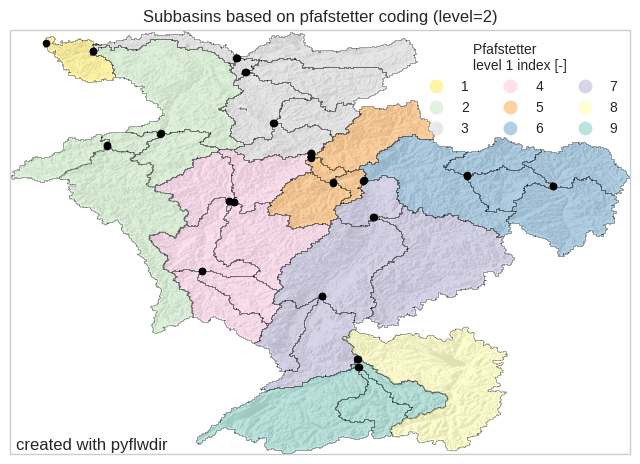

In [8]:
# plot
bas = (gdf_pfaf2, gpd_plot_kwds)
points = (gdf_out, dict(color="k", markersize=20))
title = "Subbasins based on pfafstetter coding (level=2)"
ax = quickplot([bas, points], title=title, filename="flw_pfafbas2")

## Minimal area based subbasins

The [subbasins_area()](reference.rst#pyflwdir.FlwdirRaster.subbasins_area) method creates subbasins with a minimal area of `area_min`.
Moving upstream from the basin outlets a new subbasin starts at tributaries with a contributing area larger than `area_min` and new interbasins when its area exceeds the `area_min`.

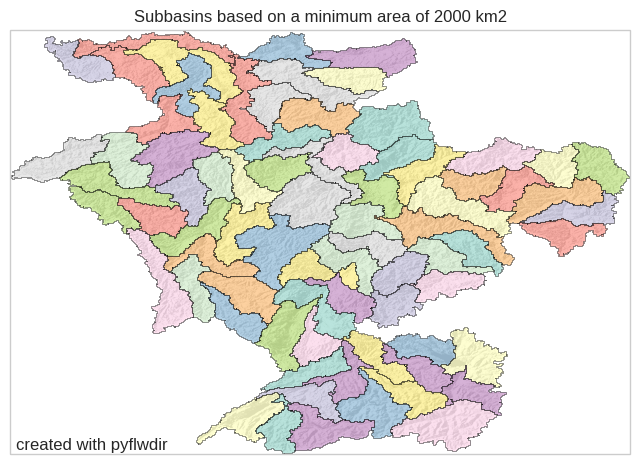

In [9]:
# calculate subbasins with a minimum stream order 7 and its outlets
min_area = 2000
subbas, idxs_out = flw.subbasins_area(min_area)
# transfrom map and point locations to GeoDataFrames
gdf_subbas = vectorize(subbas.astype(np.int32), 0, flw.transform, name="basin")
# randomize index for visualization
basids = gdf_subbas["basin"].values
gdf_subbas["color"] = np.random.choice(basids, size=basids.size, replace=False)
# plot
gpd_plot_kwds = dict(
    column="color", cmap=cm.Set3, edgecolor="black", alpha=0.6, linewidth=0.5
)
bas = (gdf_subbas, gpd_plot_kwds)
title = f"Subbasins based on a minimum area of {min_area} km2"
ax = quickplot([bas], title=title, filename="flw_subbasins_area")